In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import graphviz
import warnings
import json
from datetime import datetime

# Suppress warnings for clean output
warnings.filterwarnings('ignore')
np.random.seed(42)  # Ensuring reproducibility

# ----------------------------------------------
# Step 1: Load and Explore Data
# ----------------------------------------------

def load_and_explore_data(filepath):
    """Load dataset, display basic info, and return the DataFrame."""
    data = pd.read_csv(filepath)  # Read CSV file
    print("Dataset Shape:", data.shape)  # Show dataset dimensions
    print("\nFirst few rows:")
    display(data.head())  # Display first few rows of the dataset
    print("\nData Info:")
    display(data.info())  # Show dataset structure and data types
    print("\nMissing Values:")
    display(data.isnull().sum())  # Display count of missing values per column
    return data

# Load the air quality dataset
data = load_and_explore_data('Airqualitydata.csv')

# ----------------------------------------------
# Step 2: Data Preprocessing
# ----------------------------------------------

def handle_missing_values(df):
    """Handle missing values using KNN Imputation for numerical features and mode for categorical ones."""
    num_cols = df.select_dtypes(include=np.number).columns  # Select numerical columns
    imputer = KNNImputer(n_neighbors=5)  # Use KNN to impute missing values
    df[num_cols] = imputer.fit_transform(df[num_cols])  # Apply imputation

    # Fill missing categorical values with the most frequent category (mode)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode().iloc[0])
    
    return df

def create_new_features(df):
    """Create new engineered features such as temporal attributes and pollution ratios."""
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime format
    df['Month'] = df['Date'].dt.month  # Extract month from the date
    df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    # Encode 'Season' into numerical values
    season_encoder = LabelEncoder()
    df['Season'] = season_encoder.fit_transform(df['Season'].astype(str))

    # Create pollution ratios between major pollutants
    pollutants = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
    for i in range(len(pollutants)):
        for j in range(i + 1, len(pollutants)):
            if pollutants[i] in df.columns and pollutants[j] in df.columns:
                ratio_name = f'{pollutants[i]}_{pollutants[j]}_ratio'
                df[ratio_name] = df[pollutants[i]] / (df[pollutants[j]] + 1e-6)  # Avoid division by zero
    
    return df

def encode_categorical_features(df):
    """Encode categorical variables using appropriate encoding techniques."""
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col == 'AQI_Bucket':  # Ordinal encoding for AQI category (ordered labels)
            encoder = OrdinalEncoder(categories=[['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']])
            df[col] = encoder.fit_transform(df[[col]])
        elif col != 'City':  # Convert other categorical columns into numerical format
            df[col] = df[col].astype('category').cat.codes
    
    return df

def preprocess_data(data):
    """Apply all preprocessing functions to the dataset."""
    df = data.copy()
    df = handle_missing_values(df)  # Handle missing values
    df = create_new_features(df)  # Generate new features
    df = encode_categorical_features(df)  # Encode categorical variables
    return df

# Apply preprocessing
processed_data = preprocess_data(data)

# ----------------------------------------------
# Step 3: Feature Selection
# ----------------------------------------------

def select_features(data):
    """Select relevant features using variance thresholding and feature importance ranking."""
    features = data.drop(columns=['City', 'Date', 'AQI', 'AQI_Bucket'])  # Exclude non-relevant columns
    target_regression = data['AQI']  # Regression target variable
    target_classification = data['AQI_Bucket']  # Classification target variable

    # Remove low-variance features
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(features)
    features = features.loc[:, selector.get_support()]

    # Determine feature importance using Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(features, target_regression)
    importance_df = pd.DataFrame({'feature': features.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
    
    return features, target_regression, target_classification, importance_df

features, target_reg, target_clf, feature_importance = select_features(processed_data)

# ----------------------------------------------
# Step 4: Model Training and Evaluation
# ----------------------------------------------

def train_and_evaluate_models(features, target_reg, target_clf):
    """Train machine learning models and evaluate their performance."""
    # Split data into training and testing sets
    X_train, X_test, y_train_reg, y_test_reg = train_test_split(features, target_reg, test_size=0.2, random_state=42)
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(features, target_clf, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled_reg = scaler.fit_transform(X_train)
    X_test_scaled_reg = scaler.transform(X_test)
    X_train_scaled_clf = scaler.fit_transform(X_train_clf)
    X_test_scaled_clf = scaler.transform(X_test_clf)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced_clf, y_train_balanced_clf = smote.fit_resample(X_train_scaled_clf, y_train_clf)

    # Define models
    models = {
        'linear_regression': LinearRegression(),
        'random_forest_regression': RandomForestRegressor(random_state=42),
        'random_forest_classification': RandomForestClassifier(random_state=42),
        'svm_classification': SVC(random_state=42)
    }

    results = {}
    for name, model in models.items():
        if 'regression' in name:
            model.fit(X_train_scaled_reg, y_train_reg)
            y_pred = model.predict(X_test_scaled_reg)
            results[name] = {
                'mse': mean_squared_error(y_test_reg, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test_reg, y_pred)),
                'r2': r2_score(y_test_reg, y_pred)
            }
        else:
            model.fit(X_train_balanced_clf, y_train_balanced_clf)
            y_pred = model.predict(X_test_scaled_clf)
            results[name] = {
                'accuracy': accuracy_score(y_test_clf, y_pred),
                'precision': precision_score(y_test_clf, y_pred, average='weighted'),
                'recall': recall_score(y_test_clf, y_pred, average='weighted'),
                'f1': f1_score(y_test_clf, y_pred, average='weighted'),
                'confusion_matrix': confusion_matrix(y_test_clf, y_pred).tolist()
            }
    
    return models, results

models, results = train_and_evaluate_models(features, target_reg, target_clf)


Dataset Shape: (29531, 16)

First few rows:


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


None


Missing Values:


City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64


linear_regression:
mse: 3036.9895674040363
rmse: 55.10888827951473
r2: 0.812134088413577

random_forest_regression:
mse: 1856.3941867564915
rmse: 43.08589312938159
r2: 0.8851648389240756

random_forest_classification:
accuracy: 0.8095479939055358
precision: 0.8152463989120715
recall: 0.8095479939055358
f1: 0.8114621935986922
confusion_matrix: [[182, 49, 5, 1, 0, 0], [85, 1339, 183, 4, 0, 0], [11, 274, 2287, 150, 28, 13], [0, 1, 97, 392, 63, 0], [0, 0, 9, 61, 364, 37], [0, 0, 1, 8, 45, 218]]

svm_classification:
accuracy: 0.7365837142373455
precision: 0.773190004074214
recall: 0.7365837142373455
f1: 0.7453569192748706
confusion_matrix: [[196, 36, 3, 2, 0, 0], [248, 1205, 153, 4, 1, 0], [42, 424, 1972, 282, 26, 17], [0, 5, 66, 422, 56, 4], [0, 1, 13, 69, 337, 51], [0, 1, 3, 7, 42, 219]]


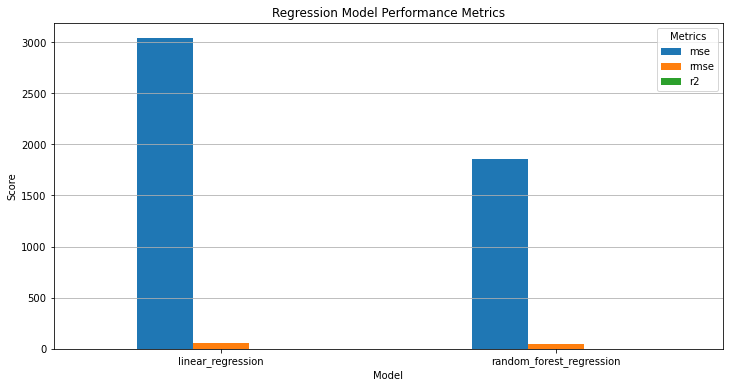

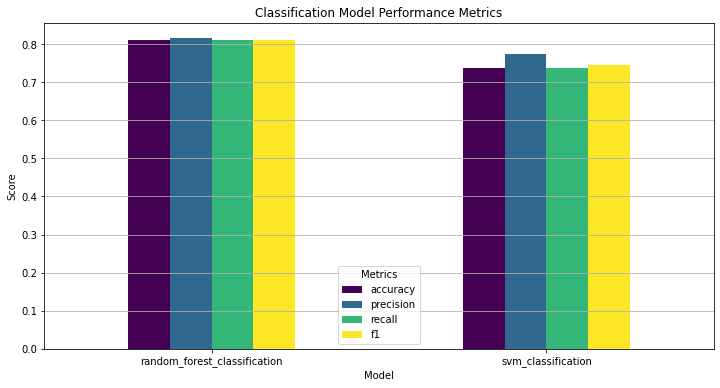

In [2]:
# Display Results
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

# Plot Results
def plot_results(results):
    # Regression Metrics
    reg_metrics = ['mse', 'rmse', 'r2']
    reg_results = {k: [v.get(metric, np.nan) for metric in reg_metrics] for k, v in results.items() if 'regression' in k}
    df_reg = pd.DataFrame(reg_results, index=reg_metrics)

    df_reg.T.plot(kind='bar', figsize=(12, 6))
    plt.title('Regression Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.legend(title='Metrics')
    plt.show()

    # Classification Metrics
    class_metrics = ['accuracy', 'precision', 'recall', 'f1']
    class_results = {k: [v.get(metric, np.nan) for metric in class_metrics] for k, v in results.items() if 'classification' in k}
    df_class = pd.DataFrame(class_results, index=class_metrics)

    df_class.T.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Classification Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.legend(title='Metrics')
    plt.show()

plot_results(results)
